### Assignment13 Requirement:
* Refer to your Assignment 12. <br>
Replace whatever model you have there with the ResNet18 model as shown below. <br>
Your model must look like Conv->B1->B2->B3->B4 and not individually called Convs. <br>
If not already using, then:<br>
* Use Batch Size 128<br>
* Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) <br> 
* Random Crop of 32 with padding of 4px<br>
* Horizontal Flip (0.5) <br>
* Optimizer: SGD, Weight-Decay: 5e-4<br>
* NOT-OneCycleLR<br>
* Save model (to drive) after every 50 epochs or best model till now Describe your blocks, and the stride strategy you have picked Train for 300 Epochs
Assignment Target Accuracy is 90%, so exit gracefully if you reach 90% (you can target more, it can go till ~93%) <br>
<br>

#### <b> Implementation: </b>
* Created custom resnet18 model. Replaced Initial conv2d of 7x7 with stride 2x2 as 3 conv2d layers with stride 1x1 that avoids loosing information in early stage of network. <br>
* Using Image Normalization. <br>
* Making use of Batch Normalization. <br>
* Removed Dense layers and used GAP. <br>
* Used Batch Size 128. <br>
* Used Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) <br>
* Used Image Augumentation and applied: Random Crop of 32 with padding of 4px <br>
* Used Image Augumentation and applied: Horizontal Flip (0.5) <br>
* Used Optimizer: SGD, Weight-Decay: 5e-4 <br>
* Used CycleLR with triangular2 policy, after modifying titu1994's code <br>
* Trained model for 200 epoches, with Image augumentation such as Random crop, horizondal flip and CycleLR with triangular2 policy. Finally it reached validation accuracy of 89.12% at 200th epoches.



In [0]:
FIRST_ITER_EPOCHS = 30  
SECOND_ITER_EPOCHS = 60  
THIRD_ITER_EPOCHS = 90
FOURTH_ITER_EPOCHS = 120  
FIFTH_ITER_EPOCHS = 150
SIXTH_ITER_EPOCHS = 200
EPOCHS = 300
#REQ1. Use Batch Size 128
BATCH_SIZE = 128
GOOGLE_DRIVE_REQ = 1
#REQ5. Optimizer: SGD, Weight-Decay: 5e-4
WEIGHT_DECAY = 5e-4
#REQ7.Save model (to drive) after every 50 epochs or best model till now


from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, GlobalAveragePooling2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
if GOOGLE_DRIVE_REQ:
  drive.mount('/gdrive')
  snapshot_filepath = "/gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5"
  model_arch_path = "/gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.json"
else:
  snapshot_filepath = "resnet18_eva_assign13.hdf5"
  model_arch_path = "resnet18_eva_assign13.json"

    


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


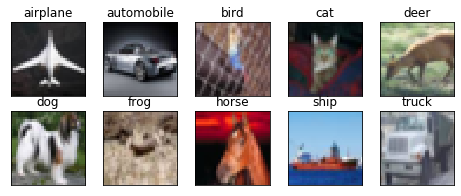

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### The model below has kind of regularization.
### Re-Running the model with below changes 
1. Using Image Normalization
2. Making use of Batch Normalization
3. Making use of L2 Regularizer
4. Removed Dense layers

### Results: Achieved a better accuracy of 84.33 % in just 15th Epoch. Ran the model further and achieved 86.36 % in 45th Epoch & 87.53 % in 89th Epoch

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

#REQ2. Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
datagen.mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.std = np.array([0.2023, 0.1994, 0.2010], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]


# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 604.6387 321.22253
(50000, 32, 32, 3) 598.4765 319.27414


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

###ResNet-18 Architecture

####Model pre-requisites

In [0]:
import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as k
#from keras.layers.merge import Concatenate
from keras.layers import Dropout, Activation, Flatten, Input, Lambda
from keras.layers.merge import add as Add

def print_layer(layer, message, first_n=3, summarize=1024):
  return keras.layers.Lambda((
    lambda x: tf.Print(x, [x],
                      message=message,
                      first_n=first_n,
                      summarize=summarize)))(layer)

def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    return tf.space_to_depth(x, block_size=2) 

def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.

    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3]) 

def Shortcut(layer1, layer2, b, l):
    print(" .. Start of Shortcut with b = ", b, " l = ", l)
    layer1_shape = K.int_shape(layer1)
    layer2_shape = K.int_shape(layer2)
    stride_width = int(round(layer1_shape[1]/layer2_shape[1]))
    stride_height = int(round(layer1_shape[2]/layer2_shape[2]))
    similar_channel = (layer1_shape[3] == layer2_shape[3])
    
    print(" .. stride_width =", stride_width, "stride_height", stride_height, "equal_channels =", similar_channel)

    if(stride_width>1 or stride_height>1 or not similar_channel):
        #print("ProjectionShortcut layer1.info = ", print_layer(layer1, "PS L1"))
        #print("ProjectionShortcut layer2.info = ", print_layer(layer2, "PS L2"))
        print("  + inside shortcut with stride_width = ", stride_width, " stride_height = ", stride_width, " equal_channels = ", similar_channel, " ... performing 1x1")
        layerName = 'Conv2d_1x1_b' + str(b) + "_l" + str(i)
        layer1_modif = Convolution2D(layer2_shape[3], (1, 1), strides=(stride_width, stride_height), padding='valid', name=layerName)(layer1)
        return Add([layer1_modif, layer2])
    else:        
        #print("IdentityShortcut layer1.info = ", print_layer(layer1, "IS L1"))
        #print("IdentityShortcut layer2.info = ", print_layer(layer2, "IS L2"))
        print("  + inside shortcut without 1x1")
        return Add([layer1, layer2])

def ResidualBlock(firstIteration, numberOfFilters, layerCount, blockCount, b, inputLayer):
    f = numberOfFilters
    x = inputLayer
    for i in range(layerCount):
        szLayerName = 'Conv2d_b' + str(blockCount) + '_l' + str(i) + '_i1'
        previousLayerOutput = x
        x = BatchNormalization() (x)
        x = Activation('relu') (x)
        strides_local=(1,1)
        if(0 == i):
            strides_local=(1,1) #(2,2)
        if(firstIteration):
            strides_local=(1,1)
        print(". a 3x3 conv2d by basic_block first half with stride =", strides_local)
        x = Convolution2D(f, (3, 3), use_bias=False, strides=strides_local, padding='same', name=szLayerName)(x)
        
        szLayerName = 'Conv2d_b' + str(blockCount) + '_l' + str(i) + '_i2'
        x = BatchNormalization() (x)
        x = Activation('relu') (x)
        print(". a 3x3 conv2d by basic_block second half with stride = (1, 1)")
        x = Convolution2D(f, (3, 3), use_bias=False, strides=(1, 1), padding='same', name=szLayerName)(x)
        print(" . input info = ", print_layer(previousLayerOutput, "input"))
        print(" . residual info = ", print_layer(x, "residual"))
        x = Shortcut(previousLayerOutput, x, b, i)
    return x
    

####Model

In [14]:

#ResNet18
cfg = [2, 2, 2, 2]

#f is number of filters
#b is block
#l is layer
#i is iteration

f = 64
x = Input(shape=(32, 32, 3,))
input = x

#Note:  Used 3x3 of 3 convolution instead of one 7x7 results in lesser number of parameters

x = Convolution2D(f, (3, 3), activation='relu', strides=(1,1), padding='same', use_bias=False, name='Conv2d_l1')(x)
x = Convolution2D(f, (3, 3), activation='relu', strides=(1,1), padding='same', use_bias=False, name='Conv2d_l2')(x)
x = Convolution2D(f, (3, 3), activation='relu', strides=(1,1), padding='same', use_bias=False, name='Conv2d_l3')(x)

x = BatchNormalization() (x)
x = Activation('relu') (x)

print(print_layer(x, "Begin x"))

x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='MP_1')(x)

for i in range(len(cfg)):
    print("\nStart line for loop i = ", i, " layers = ", cfg[i])
    x = ResidualBlock(firstIteration=(0==i), numberOfFilters=f, layerCount=cfg[i], blockCount=i+1, b=i, inputLayer=x)
    print("End line for loop _residual_block info = ", print_layer(x, "_residual_block"))
    

x = Convolution2D(10, (1, 1), name='Conv2d_1x1_last')(x)

lastLayer = GlobalAveragePooling2D()(x)

output = Activation('softmax')(lastLayer)
model1 = Model(inputs=[input], outputs=[output])













Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:

Tensor("lambda_1/Print:0", shape=(?, 32, 32, 64), dtype=float32)


Start line for loop i =  0  layers =  2
. a 3x3 conv2d by basic_block first half with stride = (1, 1)
. a 3x3 conv2d by basic_block second half with stride = (1, 1)
 . input info =  Tensor("lambda_2/Print:0", shape=(?, 32, 32, 64), dtype=float32)
 . residual info =  Tensor("lambda_3/Print:0", shape=(?, 32, 32, 64), dtype=float32)
 .. Start of Shortcut with b =  0  l =  0
 .. stride_width = 1 stride_height 1 equal_channels = True
  + inside shortcut without 1x1
. a 3x3 conv2d by basic_block first ha

###Summary

In [15]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv2d_l1 (Conv2D)              (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_l2 (Conv2D)              (None, 32, 32, 64)   36864       Conv2d_l1[0][0]                  
__________________________________________________________________________________________________
Conv2d_l3 (Conv2D)              (None, 32, 32, 64)   36864       Conv2d_l2[0][0]                  
____________________________________________________________________________________________

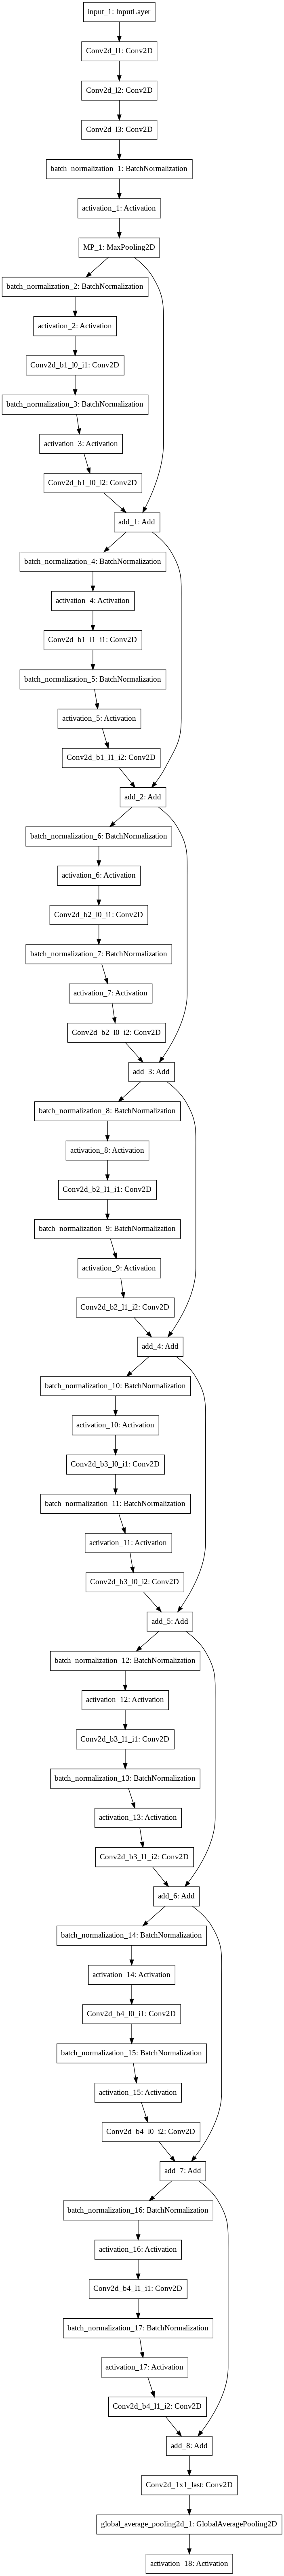

In [16]:

from keras.utils import plot_model
model1.save("test.png")
plot_model(model1, to_file='test.png')

### Total params: To-update

###CUTOUT

In [0]:
# pixel_level=False => grey patch; pixel_level=True => mixed colour patch as cutout
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False): 
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

    
    
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    

###Train and test

###Pre-requisites of Training

In [18]:
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint
import imgaug as ia
import imgaug.augmenters as iaa
from keras import optimizers
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
#REQ5. Optimizer: SGD, Weight-Decay: 5e-4
# Compile the model
sgd = optimizers.SGD(decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#REQ4.Horizontal Flip (0.5)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            px=(-32, 4),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )) #,
    ],
    random_order=True)


eraser = get_random_eraser(pixel_level=True)
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             preprocessing_function= eraser)
#datagenH = ImageDataGenerator(zoom_range=0.0, 
#                             horizontal_flip=True)
#datagenV = ImageDataGenerator(zoom_range=0.0, 
#                             vertical_flip=True)

datagenImgAug = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=seq.augment_image)
#datagenCutOut = ImageDataGenerator(zoom_range=0.0, 
#                             horizontal_flip=False,
#                             preprocessing_function = eraser)

checkpoint_savebest = ModelCheckpoint(snapshot_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


###fit generator

Saved model to disk


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=30, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390)`
  if sys.path[0] == '':


Epoch 1/30
390/390 [==============================] - 148s 381ms/step - loss: 1.7324 - acc: 0.3729 - val_loss: 2.1814 - val_acc: 0.2946

Epoch 00001: val_acc improved from -inf to 0.29460, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 2/30
390/390 [==============================] - 145s 372ms/step - loss: 1.2728 - acc: 0.5355 - val_loss: 1.5710 - val_acc: 0.4818

Epoch 00002: val_acc improved from 0.29460 to 0.48180, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 3/30
390/390 [==============================] - 146s 373ms/step - loss: 1.0920 - acc: 0.6076 - val_loss: 1.3646 - val_acc: 0.5231

Epoch 00003: val_acc improved from 0.48180 to 0.52310, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 4/30
390/390 [==============================] - 145s 373ms/step - loss: 0.9908 - acc: 0.6446 - val_loss: 1.0710 - val_acc: 0.6311

Ep

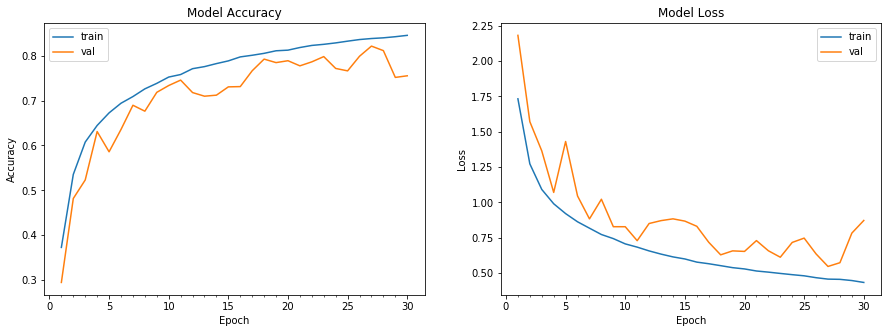

Accuracy on test data is: 75.54


In [0]:
# train the model
start = time.time()
# Save Model weight and Architecture in a separate files
# serialize model to JSON
model_json = model1.to_json()
with open(model_arch_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk") 
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], epochs = FIRST_ITER_EPOCHS, 
                                 validation_data = (X_test, Y_test), verbose=1,
                                 callbacks=[checkpoint_savebest])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
from keras.models import model_from_json

# load model architecture
json_file = open(model_arch_path, 'r')
loaded_model_json = json_file.read()
model1 = model_from_json(loaded_model_json)
json_file.close()
print("Loaded model arch fron json")


#Run for another set of epochs
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print("compile model")
model1.load_weights(snapshot_filepath)
print("load model weights")
checkpoint_savebest = ModelCheckpoint(snapshot_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Compile the model
sgd = optimizers.SGD(decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)


model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], epochs = SECOND_ITER_EPOCHS, 
                                 validation_data = (X_test, Y_test), verbose=1,
                                 initial_epoch = (FIRST_ITER_EPOCHS),
                                 callbacks=[checkpoint_savebest])


Loaded model arch fron json
compile model
load model weights


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=60, validation_data=(array([[[..., verbose=1, initial_epoch=30, callbacks=[<keras.ca..., steps_per_epoch=390)`


Epoch 31/60
390/390 [==============================] - 149s 383ms/step - loss: 0.4500 - acc: 0.8410 - val_loss: 0.6367 - val_acc: 0.7938

Epoch 00031: val_acc improved from -inf to 0.79380, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 32/60
390/390 [==============================] - 145s 372ms/step - loss: 0.4400 - acc: 0.8452 - val_loss: 0.6175 - val_acc: 0.8071

Epoch 00032: val_acc improved from 0.79380 to 0.80710, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 33/60
390/390 [==============================] - 145s 371ms/step - loss: 0.4346 - acc: 0.8478 - val_loss: 0.5216 - val_acc: 0.8283

Epoch 00033: val_acc improved from 0.80710 to 0.82830, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 34/60
390/390 [==============================] - 144s 370ms/step - loss: 0.4254 - acc: 0.8511 - val_loss: 0.5047 - val_acc: 0.8371

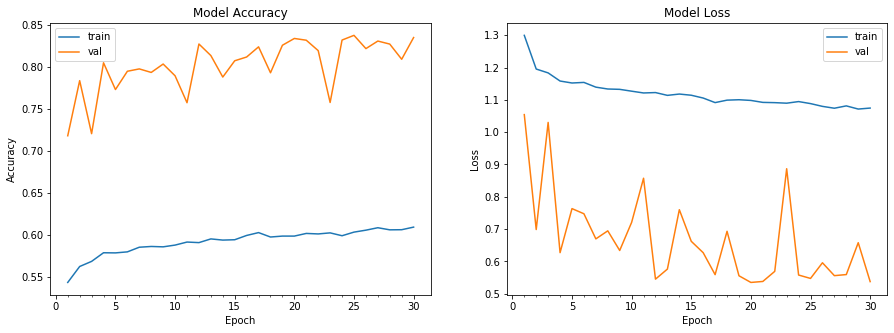

Accuracy on test data is: 83.49


In [0]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
from keras.models import model_from_json

# load model architecture
json_file = open(model_arch_path, 'r')
loaded_model_json = json_file.read()
model1 = model_from_json(loaded_model_json)
json_file.close()
print("Loaded model arch fron json")


#Run for another set of epochs
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print("compile model")
model1.load_weights(snapshot_filepath)
print("load model weights")
checkpoint_savebest = ModelCheckpoint(snapshot_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Compile the model
sgd = optimizers.SGD(decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)


model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], epochs = THIRD_ITER_EPOCHS, 
                                 validation_data = (X_test, Y_test), verbose=1,
                                 initial_epoch = SECOND_ITER_EPOCHS,
                                 callbacks=[checkpoint_savebest])


Loaded model arch fron json
compile model
load model weights


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=90, validation_data=(array([[[..., verbose=1, initial_epoch=60, callbacks=[<keras.ca..., steps_per_epoch=390)`


Epoch 61/90
390/390 [==============================] - 151s 388ms/step - loss: 0.5212 - acc: 0.8182 - val_loss: 0.9067 - val_acc: 0.7470

Epoch 00061: val_acc improved from -inf to 0.74700, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 62/90
390/390 [==============================] - 145s 371ms/step - loss: 0.4358 - acc: 0.8472 - val_loss: 0.6533 - val_acc: 0.7891

Epoch 00062: val_acc improved from 0.74700 to 0.78910, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 63/90
390/390 [==============================] - 145s 371ms/step - loss: 0.4055 - acc: 0.8590 - val_loss: 0.8811 - val_acc: 0.7601

Epoch 00063: val_acc did not improve from 0.78910
Epoch 64/90
390/390 [==============================] - 145s 372ms/step - loss: 0.3801 - acc: 0.8669 - val_loss: 0.5792 - val_acc: 0.8256

Epoch 00064: val_acc improved from 0.78910 to 0.82560, saving model to /gdrive/My Drive/Colab Noteb

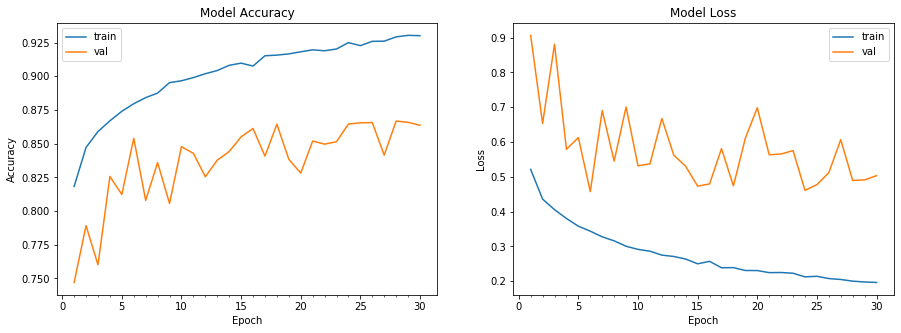

Accuracy on test data is: 86.36


In [0]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
from keras.models import model_from_json

# load model architecture
json_file = open(model_arch_path, 'r')
loaded_model_json = json_file.read()
model1 = model_from_json(loaded_model_json)
json_file.close()
print("Loaded model arch fron json")


#Run for another set of epochs
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print("compile model")
model1.load_weights(snapshot_filepath)
print("load model weights")
checkpoint_savebest = ModelCheckpoint(snapshot_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Compile the model
sgd = optimizers.SGD(decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)


model_info = model1.fit_generator(datagenImgAug.flow(X_train, Y_train, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], epochs = FOURTH_ITER_EPOCHS, 
                                 validation_data = (X_test, Y_test), verbose=1,
                                 initial_epoch = THIRD_ITER_EPOCHS,
                                 callbacks=[checkpoint_savebest])


Loaded model arch fron json
compile model
load model weights


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=120, validation_data=(array([[[..., verbose=1, initial_epoch=90, callbacks=[<keras.ca..., steps_per_epoch=390)`


Epoch 91/120
390/390 [==============================] - 186s 476ms/step - loss: 1.3078 - acc: 0.5315 - val_loss: 1.1606 - val_acc: 0.6874

Epoch 00091: val_acc improved from -inf to 0.68740, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 92/120
390/390 [==============================] - 179s 460ms/step - loss: 1.1660 - acc: 0.5739 - val_loss: 0.6813 - val_acc: 0.7748

Epoch 00092: val_acc improved from 0.68740 to 0.77480, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 93/120
390/390 [==============================] - 180s 461ms/step - loss: 1.1341 - acc: 0.5843 - val_loss: 0.5224 - val_acc: 0.8298

Epoch 00093: val_acc improved from 0.77480 to 0.82980, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 94/120
390/390 [==============================] - 180s 461ms/step - loss: 1.1136 - acc: 0.5933 - val_loss: 0.5426 - val_acc: 0.

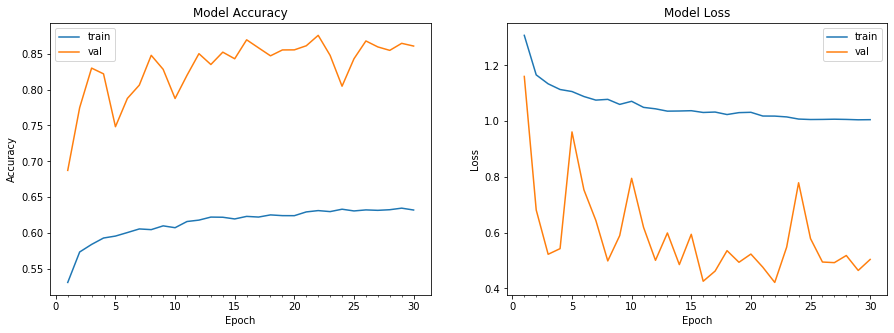

Accuracy on test data is: 86.05


In [0]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
#Run for another set of epochs
from keras.models import model_from_json

# load model architecture
json_file = open(model_arch_path, 'r')
loaded_model_json = json_file.read()
model1 = model_from_json(loaded_model_json)
json_file.close()
print("Loaded model arch fron json")


#Run for another set of epochs
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print("compile model")
model1.load_weights(snapshot_filepath)
print("load model weights")
checkpoint_savebest = ModelCheckpoint(snapshot_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Compile the model
sgd = optimizers.SGD(decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)


model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], epochs = FIFTH_ITER_EPOCHS, 
                                 validation_data = (X_test, Y_test), verbose=1,
                                 initial_epoch = (FOURTH_ITER_EPOCHS),
                                 callbacks=[checkpoint_savebest])


Loaded model arch fron json
compile model
load model weights


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=150, validation_data=(array([[[..., verbose=1, initial_epoch=120, callbacks=[<keras.ca..., steps_per_epoch=390)`


Epoch 121/150
390/390 [==============================] - 153s 394ms/step - loss: 0.3838 - acc: 0.8641 - val_loss: 0.9701 - val_acc: 0.7351

Epoch 00121: val_acc improved from -inf to 0.73510, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 122/150
390/390 [==============================] - 146s 374ms/step - loss: 0.3337 - acc: 0.8822 - val_loss: 0.4716 - val_acc: 0.8579

Epoch 00122: val_acc improved from 0.73510 to 0.85790, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Epoch 123/150
390/390 [==============================] - 146s 374ms/step - loss: 0.3051 - acc: 0.8897 - val_loss: 0.6082 - val_acc: 0.8342

Epoch 00123: val_acc did not improve from 0.85790
Epoch 124/150
390/390 [==============================] - 146s 374ms/step - loss: 0.2847 - acc: 0.8988 - val_loss: 0.7166 - val_acc: 0.8104

Epoch 00124: val_acc did not improve from 0.85790
Epoch 125/150
390/390 [==================

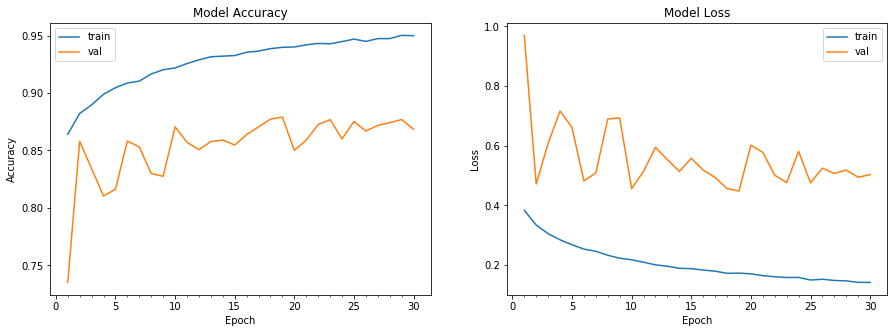

Accuracy on test data is: 86.84


In [0]:

# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
# Clyclic LR
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
class StopAtAccValue(Callback):
  def __init__(self,validation_iterator, threshold = 0.9, ):
    super(StopAtAccValue, self).__init__()
    self.threshold = threshold
    self.validation_iterator = validation_iterator
  def on_epoch_end(self, epoch, logs={}):
    score = self.model.evaluate_generator(self.validation_iterator,steps=len(self.validation_iterator))
    acc = score[1]
    if acc >= self.threshold:
      self.model.stop_training = True
      print("Stopping Training:: Val Acc = %.3f Achieved"%(acc))
    else:
      print("Continue Training:: Val Acc = %.3f, Threshold = %.3f"%(acc,self.threshold))

In [21]:

# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.001


#Run for another set of epochs
from keras.models import model_from_json

# load model architecture
json_file = open(model_arch_path, 'r')
loaded_model_json = json_file.read()
model1 = model_from_json(loaded_model_json)
json_file.close()
print("Loaded model arch fron json")


#Run for another set of epochs
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print("compile model")
model1.load_weights(snapshot_filepath)
print("load model weights")
checkpoint_savebest = ModelCheckpoint(snapshot_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Compile the model
train_iterator = datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE,shuffle=True)

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=BATCH_SIZE,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular2')
						
						
callbacks=[clr,checkpoint_savebest,stopper]

# Compile the model
sgd = optimizers.SGD(decay=WEIGHT_DECAY, momentum=0.90, nesterov=True)

start_time = time.time()
model_info = model1.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), 
                                    epochs = SIXTH_ITER_EPOCHS, validation_data = validation_iterator, 
                                    initial_epoch = (FIFTH_ITER_EPOCHS), validation_steps = len(validation_iterator),
                                    verbose=1,callbacks=callbacks)



Loaded model arch fron json
compile model
load model weights
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 151/200
391/391 [==============================] - 46s 117ms/step - loss: 0.1333 - acc: 0.9520 - val_loss: 0.5281 - val_acc: 0.8778

Epoch 00151: val_acc improved from -inf to 0.87780, saving model to /gdrive/My Drive/Colab Notebooks/EVA/assignment13/resnet18_eva_assign13_v2.hdf5
Continue Training:: Val Acc = 0.878, Threshold = 0.900
Epoch 152/200
391/391 [==============================] - 41s 104ms/step - loss: 0.1484 - acc: 0.9469 - val_loss: 0.6308 - val_acc: 0.8510

Epoch 00152: val_acc did not improve from 0.87780
Continue Training:: Val Acc = 0.851, Threshold = 0.900
Epoch 153/200
391/391 [==============================] - 41s 104ms/step - loss: 0.1598 - acc: 0.9436 - val_loss: 0.5165 - val_acc: 0.8660

Epoch 00153: val_acc did not improve from 0.87780
Continue Training:: Val Acc = 0.868, Threshold = 0.900
Epoch 154/200


#### 



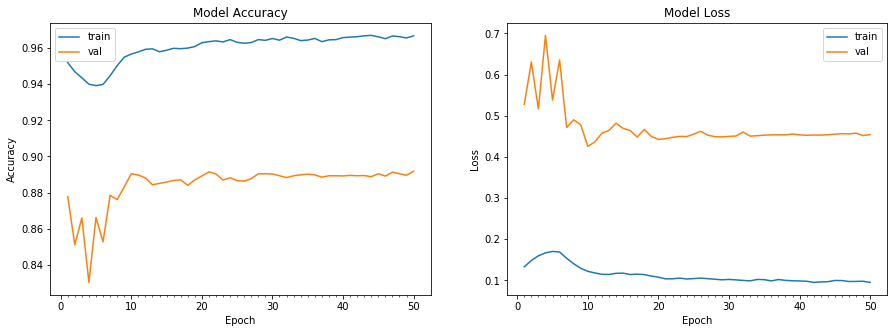

Accuracy on test data is: 89.18


In [22]:

# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))